## MD Capstone Final Project 

#### Analysing the Cost of Living in New York City compare with the neighbouhood locations

In [2]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes 

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  17.82 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  37.79 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  49.24 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  34.82 MB/s
vincent-0.4.4- 100% |###################

In [49]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.pyplot as plt

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Exploring of the dataset

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('NY Data has downloaded!')

NY Data has downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    NY_data = json.load(json_data)

In [6]:
neighborhoods_data = NY_data['features']

In [7]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_data = pd.DataFrame(columns=column_names)

In [9]:
newyork_data

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
newyork_data.head(10)

Borough    Neighborhood   Latitude  Longitude
0      Bronx       Wakefield  40.894705 -73.847201
1      Bronx      Co-op City  40.874294 -73.829939
2      Bronx     Eastchester  40.887556 -73.827806
3      Bronx       Fieldston  40.895437 -73.905643
4      Bronx       Riverdale  40.890834 -73.912585
5      Bronx     Kingsbridge  40.881687 -73.902818
6  Manhattan     Marble Hill  40.876551 -73.910660
7      Bronx        Woodlawn  40.898273 -73.867315
8      Bronx         Norwood  40.877224 -73.879391
9      Bronx  Williamsbridge  40.881039 -73.857446

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(newyork_data['Borough'].unique()),
        newyork_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Foursquare Credentials and Version

In [13]:
CLIENT_ID = '3KILTSBN4DBAISVIIMDSGGWUQFQ40VMTLOZRBXEYRXE2FLN3' # your Foursquare ID
CLIENT_SECRET = 'XQ5K1YM3HBUNAXNPUWFM0FM5R2C1OR4HTB5YKVEAMSVYGPXP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3KILTSBN4DBAISVIIMDSGGWUQFQ40VMTLOZRBXEYRXE2FLN3
CLIENT_SECRET:XQ5K1YM3HBUNAXNPUWFM0FM5R2C1OR4HTB5YKVEAMSVYGPXP


In [14]:
newyork_data.loc[0, 'Neighborhood']

'Wakefield'

#### latitude and longitude values of New York City

In [15]:
neighborhood_latitude = newyork_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = newyork_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = newyork_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


#### Get the top 100 venues that are in Wakefield within a radius of 500 meters

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=3KILTSBN4DBAISVIIMDSGGWUQFQ40VMTLOZRBXEYRXE2FLN3&client_secret=XQ5K1YM3HBUNAXNPUWFM0FM5R2C1OR4HTB5YKVEAMSVYGPXP&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&limit=100'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c8b70c6351e3d34d5f08c8e'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c537892fd2ea593cb077a28-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1d0941735',
         'name': 'Dessert Shop',
         'pluralName': 'Dessert Shops',
         'primary': True,
         'shortName': 'Desserts'}],
       'id': '4c537892fd2ea593cb077a28',
       'location': {'address': '4120 Baychester Ave',
        'cc': 'US',
        'city': 'Bronx',
        'country': 'United States',
        'crossStreet': 'Edenwald & Bussing Ave',
        'distance': 127,
        'formattedAddress': ['4120 Baychester Ave (Edenwald & Bussing Ave)',
         'Bronx, NY 10466',
         'United 

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name      categories        lat        lng
0  Lollipops Gelato    Dessert Shop  40.894123 -73.845892
1          Rite Aid        Pharmacy  40.896649 -73.844846
2  Carvel Ice Cream  Ice Cream Shop  40.890487 -73.848568
3     Dunkin Donuts      Donut Shop  40.890631 -73.849027
4            SUBWAY  Sandwich Place  40.890656 -73.849192

In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',                   
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
newyork_venues = getNearbyVenues(names=newyork_data['Neighborhood'],
                                   latitudes=newyork_data['Latitude'],
                                   longitudes=newyork_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### size of the resulting dataframe of New York City

In [23]:
print(newyork_venues.shape)
newyork_venues.head()

(10259, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3     Dunkin Donuts       40.890631       -73.849027      Donut Shop  
4            SUBWAY       40.890656       -73.849192  Sandwich Place

#### how many venues were returned for each neighborhood

In [61]:
newyork_venues.groupby('Venue Category').count().reset_index()

Venue Category  Neighborhood  \
0                                         ATM             1   
1                           Accessories Store            10   
2                              Adult Boutique             3   
3                           Afghan Restaurant             3   
4                          African Restaurant             5   
5                                Airport Tram             1   
6                         American Restaurant           168   
7                              Animal Shelter             1   
8                                Antique Shop            12   
9                                      Arcade             3   
10                           Arepa Restaurant            10   
11                     Argentinian Restaurant             9   
12                                Art Gallery            54   
13                                 Art Museum             6   
14                        Arts & Crafts Store            16   
15                       Arts & Entertainment             2   
16                           Asian Restaurant            58   
17                         Athletics & Sports            17   
18                                 Auditorium             1   
19                      Australian Restaurant             4   
20                        Austrian Restaurant             2   
21                              Auto Workshop             2   
22                            Automotive Shop             2   
23                                  BBQ Joint            30   
24                                 Baby Store             1   
25                                 Bagel Shop           114   
26                                     Bakery           236   
27                                       Bank           122   
28                                        Bar           220   
29                             Baseball Field            20   
30                           Baseball Stadium             3   
31                           Basketball Court            13   
32                                 Bath House             1   
33                                      Beach            44   
34                                  Beach Bar             2   
35                            Bed & Breakfast             2   
36                                   Beer Bar            15   
37                                Beer Garden            15   
38                                 Beer Store             7   
39                              Big Box Store             5   
40                   Bike Rental / Bike Share             2   
41                                  Bike Shop             2   
42                                 Bike Trail             1   
43                                     Bistro             6   
44                                 Board Shop             9   
45                              Boat or Ferry             9   
46                                  Bookstore            54   
47                                   Boutique            43   
48                              Bowling Alley             9   
49                                 Boxing Gym             9   
50                       Brazilian Restaurant             6   
51                             Breakfast Spot            37   
52                                    Brewery            16   
53                                Bridal Shop             2   
54                                     Bridge             3   
55                            Bubble Tea Shop            28   
56                                     Buffet             4   
57                                   Building             9   
58                               Burger Joint            83   
59                              Burrito Place            10   
60                                   Bus Line             7   
61                                Bus Station            73   
62                                   Bus Stop            75   

In [62]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 426 uniques categories.


### Analysing each Neighborhood

In [26]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

Yoga Studio  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0    0                  0               0                  0   
1            0    0                  0               0                  0   
2            0    0                  0               0                  0   
3            0    0                  0               0                  0   
4            0    0                  0               0                  0   

   African Restaurant  Airport Tram  American Restaurant  Animal Shelter  \
0                   0             0                    0               0   
1                   0             0                    0               0   
2                   0             0                    0               0   
3                   0             0                    0               0   
4                   0             0                    0               0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0       0                 0                       0   
1             0       0                 0                       0   
2             0       0                 0                       0   
3             0       0                 0                       0   
4             0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   
3                 0                   0           0                      0   
4                 0                   0           0                      0   

   Austrian Restaurant  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0                    0              0                0          0           0   
1                    0              0                0          0           0   
2                    0              0                0          0           0   
3                    0              0                0          0           0   
4                    0              0                0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           0       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Court  Bath House  Beach  Beach Bar  Bed & Breakfast  Beer Bar  \
0                 0           0      0          0                0         0   
1                 0           0      0          0                0         0   
2                 0           0      0          0                0         0   
3                 0           0      0          0                0         0   
4                 0           0      0          0                0         0   

   Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0            0           0              0                         0   
1            0           0              0                         0   
2            0           0              0                         0   
3            0           0              0                         0   
4            0  

In [55]:
newyork_onehot.shape

(10259, 426)

In [57]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

Neighborhood  Yoga Studio       ATM  Accessories Store  \
0                     Allerton     0.000000  0.000000           0.000000   
1                     Annadale     0.000000  0.000000           0.000000   
2                Arden Heights     0.000000  0.000000           0.000000   
3                    Arlington     0.000000  0.000000           0.000000   
4                     Arrochar     0.000000  0.000000           0.000000   
5                      Arverne     0.000000  0.000000           0.000000   
6                      Astoria     0.000000  0.000000           0.000000   
7              Astoria Heights     0.000000  0.000000           0.000000   
8                   Auburndale     0.000000  0.000000           0.000000   
9                   Bath Beach     0.000000  0.000000           0.000000   
10           Battery Park City     0.000000  0.000000           0.000000   
11                   Bay Ridge     0.000000  0.000000           0.000000   
12                 Bay Terrace     0.000000  0.000000           0.019231   
13                  Baychester     0.000000  0.000000           0.000000   
14                     Bayside     0.014286  0.000000           0.000000   
15                   Bayswater     0.000000  0.000000           0.000000   
16                Bedford Park     0.000000  0.000000           0.000000   
17          Bedford Stuyvesant     0.000000  0.000000           0.000000   
18                  Beechhurst     0.100000  0.000000           0.000000   
19                    Bellaire     0.000000  0.000000           0.000000   
20                Belle Harbor     0.000000  0.000000           0.000000   
21                   Bellerose     0.000000  0.000000           0.000000   
22                     Belmont     0.000000  0.000000           0.000000   
23                 Bensonhurst     0.000000  0.000000           0.000000   
24                Bergen Beach     0.000000  0.000000           0.000000   
25                  Blissville     0.000000  0.000000           0.000000   
26                  Bloomfield     0.000000  0.000000           0.000000   
27                 Boerum Hill     0.024390  0.000000           0.000000   
28                Borough Park     0.000000  0.000000           0.000000   
29                Breezy Point     0.000000  0.000000           0.000000   
30                   Briarwood     0.000000  0.000000           0.000000   
31              Brighton Beach     0.000000  0.000000           0.000000   
32               Broad Channel     0.000000  0.000000           0.000000   
33           Broadway Junction     0.000000  0.000000           0.000000   
34                   Bronxdale     0.000000  0.000000           0.000000   
35            Brooklyn Heights     0.050000  0.000000           0.000000   
36                  Brookville     0.000000  0.000000           0.000000   
37                 Brownsville     0.000000  0.000000           0.000000   
38                  Bulls Head     0.000000  0.000000           0.000000   
39                    Bushwick     0.000000  0.000000           0.000000   
40                Butler Manor     0.000000  0.000000           0.000000   
41             Cambria Heights     0.000000  0.000000           0.000000   
42                    Canarsie     0.000000  0.000000           0.000000   
43               Carnegie Hill     0.030000  0.000000           0.000000   
44             Carroll Gardens     0.000000  0.000000           0.000000   
45                 Castle Hill     0.000000  0.000000           0.000000   
46           Castleton Corners     0.000000  0.000000           0.000000   
47              Central Harlem     0.000000  0.000000           0.000000   
48                  Charleston     0.000000  0.000000           0.000000   
49                     Chelsea     0.000000  0.000000           0.000000   
50                   Chinatown     0.000000  0.000000           0.000000   
51                 City Island     0.000000  0.000000           0.

In [58]:
newyork_grouped.shape

(301, 426)

#### Create the new dataframe and display the top 10 venues for each neighborhood

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Supermarket                Bakery   
1       Annadale           Pizza Place   American Restaurant   
2  Arden Heights         Deli / Bodega           Pizza Place   
3      Arlington           Coffee Shop   American Restaurant   
4       Arrochar              Bus Stop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0          Liquor Store                   Spa               Pizza Place   
1            Sports Bar          Dance Studio                Restaurant   
2           Coffee Shop              Bus Stop                  Pharmacy   
3         Boat or Ferry              Bus Stop             Grocery Store   
4           Pizza Place         Deli / Bodega  Mediterranean Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Spanish Restaurant            Playground    Chinese Restaurant   
1                  Park                 Diner         Train Station   
2         Women's Store                 Field           Event Space   
3         Women's Store     Fish & Chips Shop            Eye Doctor   
4          Liquor Store        Sandwich Place            Taco Place   

  9th Most Common Venue 10th Most Common Venue  
0  Fast Food Restaurant      Martial Arts Dojo  
1        Farmers Market                   Farm  
2               Exhibit             Eye Doctor  
3               Factory     Falafel Restaurant  
4            Bagel Shop                  Hotel

### Cluster Neighborhoods

In [32]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15] 

array([4, 4, 4, 3, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_,0)

newyork_merged = newyork_data

newyork_merged = newyork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  ClusterLabels  \
0   Bronx    Wakefield  40.894705 -73.847201            0.0   
1   Bronx   Co-op City  40.874294 -73.829939            4.0   
2   Bronx  Eastchester  40.887556 -73.827806            4.0   
3   Bronx    Fieldston  40.895437 -73.905643            0.0   
4   Bronx    Riverdale  40.890834 -73.912585            0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place  Caribbean Restaurant              Pharmacy   
1           Bus Station        Mattress Store        Ice Cream Shop   
2  Caribbean Restaurant           Bus Station                 Diner   
3                 River            Playground                 Plaza   
4                  Park            Food Truck           Bus Station   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Laundromat        Ice Cream Shop          Dessert Shop   
1              Pharmacy                  Park         Grocery Store   
2    Chinese Restaurant  Fast Food Restaurant         Deli / Bodega   
3         Women's Store                 Field         Event Service   
4                   Gym          Home Service            Playground   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Food            Food Truck            Donut Shop   
1           Pizza Place  Fast Food Restaurant      Basketball Court   
2           Pizza Place              Platform        Cosmetics Shop   
3           Event Space               Exhibit            Eye Doctor   
4                  Bank                 Plaza         Women's Store   

  10th Most Common Venue  
0                Factory  
1         Discount Store  
2          Bowling Alley  
3                Factory  
4         Farmers Market

In [34]:
newyork_merged['ClusterLabels'] = newyork_merged['ClusterLabels'].fillna(0) 
newyork_merged.ClusterLabels = newyork_merged.ClusterLabels.astype(int)

In [35]:
newyork_merged.head()

Borough Neighborhood   Latitude  Longitude  ClusterLabels  \
0   Bronx    Wakefield  40.894705 -73.847201              0   
1   Bronx   Co-op City  40.874294 -73.829939              4   
2   Bronx  Eastchester  40.887556 -73.827806              4   
3   Bronx    Fieldston  40.895437 -73.905643              0   
4   Bronx    Riverdale  40.890834 -73.912585              0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0        Sandwich Place  Caribbean Restaurant              Pharmacy   
1           Bus Station        Mattress Store        Ice Cream Shop   
2  Caribbean Restaurant           Bus Station                 Diner   
3                 River            Playground                 Plaza   
4                  Park            Food Truck           Bus Station   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Laundromat        Ice Cream Shop          Dessert Shop   
1              Pharmacy                  Park         Grocery Store   
2    Chinese Restaurant  Fast Food Restaurant         Deli / Bodega   
3         Women's Store                 Field         Event Service   
4                   Gym          Home Service            Playground   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Food            Food Truck            Donut Shop   
1           Pizza Place  Fast Food Restaurant      Basketball Court   
2           Pizza Place              Platform        Cosmetics Shop   
3           Event Space               Exhibit            Eye Doctor   
4                  Bank                 Plaza         Women's Store   

  10th Most Common Venue  
0                Factory  
1         Discount Store  
2          Bowling Alley  
3                Factory  
4         Farmers Market

### Merging of Cost of Living with the New York Dataframe

In [36]:
newyork_merged.groupby('ClusterLabels').mean()

Latitude  Longitude
ClusterLabels                      
0              40.700885 -73.951440
1              40.597390 -73.953988
2              40.599073 -74.148106
3              40.625365 -74.113058
4              40.712876 -73.919270

In [37]:
filtered_columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
newyork_fdata = newyork_merged.loc[:, filtered_columns]
newyork_fdata['COL Per Month'] = round(( newyork_fdata['Latitude'] - (round(newyork_fdata['Latitude'],1) -0.1) ) * 10000,2) 
newyork_fdata.head()

Borough Neighborhood   Latitude  Longitude  COL Per Month
0   Bronx    Wakefield  40.894705 -73.847201         947.05
1   Bronx   Co-op City  40.874294 -73.829939         742.94
2   Bronx  Eastchester  40.887556 -73.827806         875.56
3   Bronx    Fieldston  40.895437 -73.905643         954.37
4   Bronx    Riverdale  40.890834 -73.912585         908.34

In [38]:
newyork_fdata.groupby(['Borough']).mean()

Latitude  Longitude  COL Per Month
Borough                                           
Bronx          40.850482 -73.873442    1043.278654
Brooklyn       40.651089 -73.952999     996.607000
Manhattan      40.762438 -73.975329    1024.384000
Queens         40.706424 -73.824131     977.821728
Staten Island  40.588851 -74.137414    1110.731587

In [52]:
filtered_columns = ['Borough', 'Neighborhood'] 
newyork_cdata = newyork_merged.loc[:, filtered_columns]
newyork_cdata = newyork_cdata.groupby(['Borough']).count()
newyork_cdata

Neighborhood
Borough                    
Bronx                    52
Brooklyn                 70
Manhattan                40
Queens                   81
Staten Island            63

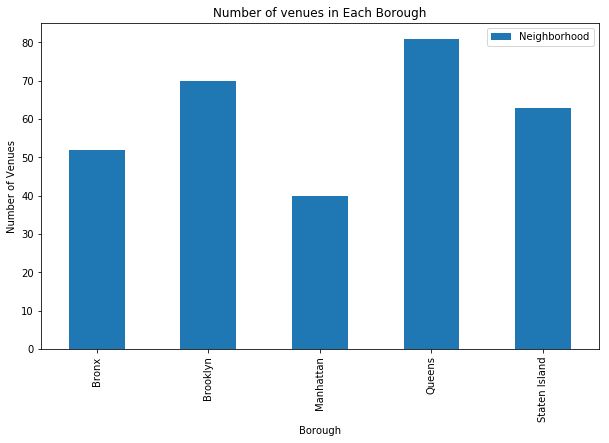

In [53]:
newyork_cdata.plot(kind='bar',figsize=(10, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Borough')
plt.ylabel('Number of Venues')
plt.title('Number of venues in Each Borough')

plt.show()

In [56]:
#newyork_data.merge(newyork_fdata, on='Latitude')
newyork_result = newyork_fdata.merge(newyork_merged, how='inner', on=['Latitude', 'Longitude','Borough','Neighborhood'])
newyork_result

Borough               Neighborhood   Latitude  Longitude  \
0            Bronx                  Wakefield  40.894705 -73.847201   
1            Bronx                 Co-op City  40.874294 -73.829939   
2            Bronx                Eastchester  40.887556 -73.827806   
3            Bronx                  Fieldston  40.895437 -73.905643   
4            Bronx                  Riverdale  40.890834 -73.912585   
5            Bronx                Kingsbridge  40.881687 -73.902818   
6        Manhattan                Marble Hill  40.876551 -73.910660   
7            Bronx                   Woodlawn  40.898273 -73.867315   
8            Bronx                    Norwood  40.877224 -73.879391   
9            Bronx             Williamsbridge  40.881039 -73.857446   
10           Bronx                 Baychester  40.866858 -73.835798   
11           Bronx             Pelham Parkway  40.857413 -73.854756   
12           Bronx                City Island  40.847247 -73.786488   
13           Bronx               Bedford Park  40.870185 -73.885512   
14           Bronx         University Heights  40.855727 -73.910416   
15           Bronx             Morris Heights  40.847898 -73.919672   
16           Bronx                    Fordham  40.860997 -73.896427   
17           Bronx               East Tremont  40.842696 -73.887356   
18           Bronx                 West Farms  40.839475 -73.877745   
19           Bronx               High  Bridge  40.836623 -73.926102   
20           Bronx                    Melrose  40.819754 -73.909422   
21           Bronx                 Mott Haven  40.806239 -73.916100   
22           Bronx                Port Morris  40.801664 -73.913221   
23           Bronx                   Longwood  40.815099 -73.895788   
24           Bronx                Hunts Point  40.809730 -73.883315   
25           Bronx                 Morrisania  40.823592 -73.901506   
26           Bronx                  Soundview  40.821012 -73.865746   
27           Bronx               Clason Point  40.806551 -73.854144   
28           Bronx                Throgs Neck  40.815109 -73.816350   
29           Bronx               Country Club  40.844246 -73.824099   
30           Bronx                Parkchester  40.837938 -73.856003   
31           Bronx         Westchester Square  40.840619 -73.842194   
32           Bronx                   Van Nest  40.843608 -73.866299   
33           Bronx                Morris Park  40.847549 -73.850402   
34           Bronx                    Belmont  40.857277 -73.888452   
35           Bronx             Spuyten Duyvil  40.881395 -73.917190   
36           Bronx            North Riverdale  40.908543 -73.904531   
37           Bronx                 Pelham Bay  40.850641 -73.832074   
38           Bronx              Schuylerville  40.826580 -73.826203   
39           Bronx             Edgewater Park  40.821986 -73.813885   
40           Bronx                Castle Hill  40.819014 -73.848027   
41           Bronx                  Olinville  40.871371 -73.863324   
42           Bronx             Pelham Gardens  40.862966 -73.841612   
43           Bronx                  Concourse  40.834284 -73.915589   
44           Bronx                  Unionport  40.829774 -73.850535   
45           Bronx                   Edenwald  40.884561 -73.848083   
46        Brooklyn                  Bay Ridge  40.625801 -74.030621   
47        Brooklyn                Bensonhurst  40.611009 -73.995180   
48        Brooklyn                Sunset Park  40.645103 -74.010316   
49        Brooklyn                 Greenpoint  40.730201 -73.954241   
50        Brooklyn                  Gravesend  40.595260 -73.973471   
51        Brooklyn             Brighton Beach  40.576825 -73.965094   
52        Brooklyn             Sheepshead Bay  40.586890 -73.943186   
53        Brooklyn          Manhattan Terrace  40.614433 -73.957438   
54        Brooklyn                   Flatbush  40.636326 -73.958401   
55        Brooklyn              Cro

In [59]:
filtered_columns = ['Borough', 'COL Per Month'] 
newyork_bchart = newyork_result.loc[:, filtered_columns]  
newyork_bchart = newyork_bchart.groupby(['Borough']).mean()
newyork_bchart

COL Per Month
Borough                     
Bronx            1043.278654
Brooklyn          996.607000
Manhattan        1024.384000
Queens            977.821728
Staten Island    1110.731587

#### Creating a Bar chart to Analyse the Cost of Living based on Borough

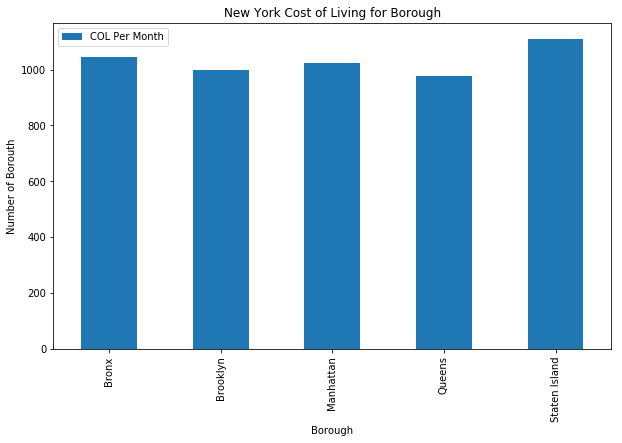

In [60]:

newyork_bchart.plot(kind='bar',figsize=(10, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Borough')
plt.ylabel('Number of Borouth')
plt.title('New York Cost of Living for Borough')

plt.show()

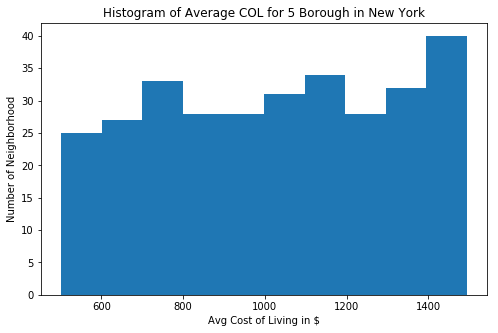

In [62]:

newyork_result['COL Per Month'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of Average COL for 5 Borough in New York') # add a title to the histogram
plt.ylabel('Number of Neighborhood') # add y-label
plt.xlabel('Avg Cost of Living in $') # add x-label

plt.show()

In [63]:
# download countries geojson file
!wget --quiet https://ibm.box.com/shared/static/cto2qv7nx6yq19logfcissyy4euo8lho.json -O world_countries.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [64]:
world_geo = r'world_countries.json' # geojson file

# create a plain world map
world_map = folium.Map(location=[0, 0], zoom_start=2, tiles='Mapbox Bright')

#### Ploting the Cost of Living into Choropleth Map

In [65]:
world_geo = r'world_countries.json'

threshold_scale = np.linspace(newyork_result['COL Per Month'].min(),
                              newyork_result['COL Per Month'].max(),
                              5, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 

#[40.7308619, -73.9871558]
world_map = folium.Map(location=[40.7308619, -73.9871558], zoom_start=5)

world_map.choropleth(
    geo_data=world_geo,
    data=newyork_result,
    columns=['Borough', 'COL Per Month'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name='Cost of Living - Newyork',
    reset=True
)

world_map

In [70]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [71]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Borough'], newyork_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Generating the Map and Differencating the Neighborhood Clustering by Color

In [69]:
# create map Need to finish it here to combine with the another pricing dat set to proceed
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters